<a href="https://colab.research.google.com/github/shuchangliang/german_credit_risk/blob/main/German_Credit_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




---


### **About Dataset**
The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes. The link to the original dataset can be found below.



---


### **Content**
It is almost impossible to understand the original dataset due to its complicated system of categories and symbols. Thus, I wrote a small Python script to convert it into a readable CSV file. Several columns are simply ignored, because in my opinion either they are not important or their descriptions are obscure. The selected attributes are:

- Age (numeric)
- Sex (text: male, female)
- Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - - skilled, 3 - highly skilled)
- Housing (text: own, rent, or free)
- Saving accounts (text - little, moderate, quite rich, rich)
- Checking account (numeric, in DM - Deutsch Mark)
- Credit amount (numeric, in DM)
- Duration (numeric, in month)
- Purpose (text: car, furniture/equipment, radio/TV, domestic appliances repairs, education, business, vacation/others)


---


### **Acknowledgements**
Source: https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data


---


### **Contexts**
Through visual analysis, we conducted an initial exploration of the data and used cluster analysis to classify customers into different risk groups. Since the dataset lacked direct customer loan risk labels, we couldn't directly assess the accuracy of the risk classification. Therefore, we performed another round of cluster analysis (without considering customer loan risk characteristics) and divided the data into four categories. The classification results aligned with reality, allowing us to build a random forest model to identify key factors in risk classification. Although the model's accuracy cannot be precisely evaluated, it can still serve as an effective tool for preliminary risk assessment, thus improving the efficiency of risk identification.

## 1. **Libraries and Load Data**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
data = pd.read_csv("german_credit_data.csv")
data.sample(5)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
439,439,26,female,0,own,little,rich,609,12,business
443,443,41,male,1,own,little,NaN,719,12,education
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
650,650,50,male,3,free,little,little,7476,48,education
955,955,57,female,3,rent,rich,little,1231,24,radio/TV


## 2. **Data Preview and Pre-process**

### 2.1. **Data Preview**

In [3]:
data.shape

(1000, 10)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


In [5]:
# rename Unnamed: 0 to be Id, and change type to string
data = data.rename(columns={'Unnamed: 0': 'Id'})
data['Id'] = data['Id'].astype(str)

In [6]:
data.isna().sum()

,0
Id,0
Age,0
Sex,0
Job,0
Housing,0
Saving accounts,183
Checking account,394
Credit amount,0
Duration,0
Purpose,0


In [7]:
data.duplicated().sum()

0

### 2.2. **Data Pre-process**

In [8]:
# Handle missing values ​​in Saving accounts and Checking accounts.
# Considering that missing values ​​account for a large proportion, it is not recommended to delete them directly.
# Similarly, it is not recommended to fill them with the mode, which may change the data situation. Here, fill them with unknown.

In [9]:
data['Saving accounts'].fillna('unknown', inplace=True)
data['Checking account'].fillna('unknown', inplace=True)
data.isna().sum()

,0
Id,0
Age,0
Sex,0
Job,0
Housing,0
Saving accounts,0
Checking account,0
Credit amount,0
Duration,0
Purpose,0


In [10]:
# View the unique values ​​of categorical features
characteristic = ['Sex','Job','Housing','Saving accounts','Checking account','Purpose']
for i in characteristic:
    print(f'{i}:')
    print(data[i].unique())
    print('-'*50)

Sex:
['male' 'female']
--------------------------------------------------
Job:
[2 1 3 0]
--------------------------------------------------
Housing:
['own' 'free' 'rent']
--------------------------------------------------
Saving accounts:
['unknown' 'little' 'quite rich' 'rich' 'moderate']
--------------------------------------------------
Checking account:
['little' 'moderate' 'unknown' 'rich']
--------------------------------------------------
Purpose:
['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
--------------------------------------------------


## 3. **Data Explore**

### 3.1 **Analysis of basic customer situation**

<ipython-input-11-0877e0557727>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Age'], kde=True, bins=30, ax=axs[0, 0])
<ipython-input-11-0877e0557727>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sex', data=data, palette='Set2', ax=axs[0, 1])
<ipython-input-11-0877e0557727>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x

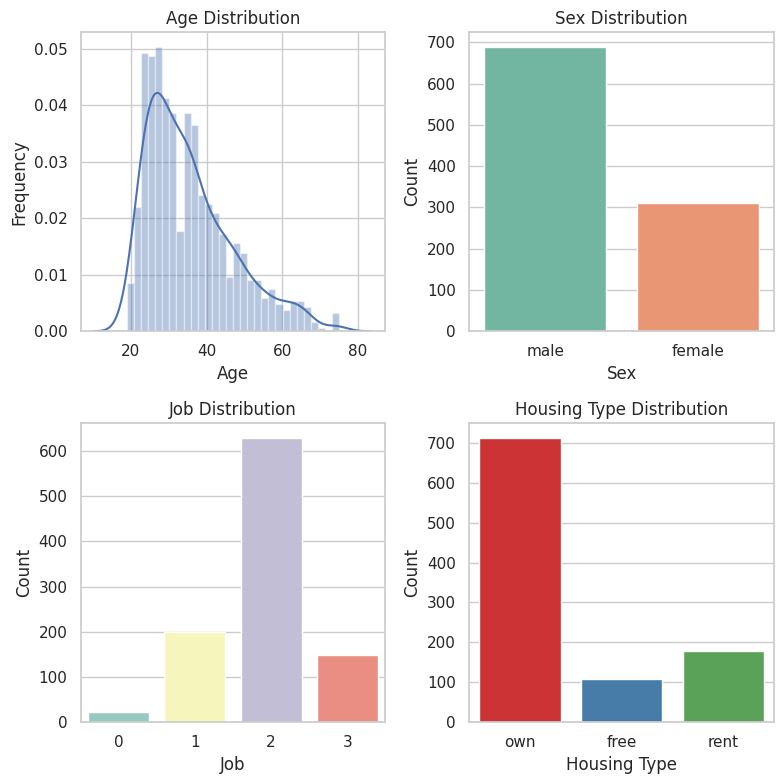

In [11]:
# Set drawing style
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(8,8))

# Age distribution
sns.distplot(data['Age'], kde=True, bins=30, ax=axs[0, 0])
axs[0, 0].set_title('Age Distribution')
axs[0, 0].set_xlabel('Age')
axs[0, 0].set_ylabel('Frequency')

# Gender distribution
sns.countplot(x='Sex', data=data, palette='Set2', ax=axs[0, 1])
axs[0, 1].set_title('Sex Distribution')
axs[0, 1].set_xlabel('Sex')
axs[0, 1].set_ylabel('Count')

# Occupational skill distribution
sns.countplot(x='Job', data=data, palette='Set3', ax=axs[1, 0])
axs[1, 0].set_title('Job Distribution')
axs[1, 0].set_xlabel('Job')
axs[1, 0].set_ylabel('Count')

# Housing type distribution
sns.countplot(x='Housing', data=data, palette='Set1', ax=axs[1, 1])
axs[1, 1].set_title('Housing Type Distribution')
axs[1, 1].set_xlabel('Housing Type')
axs[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

**The following conclusions can be drawn from the above figure:**
1. The age of customers is mainly concentrated in the younger age group (~ 25 - 30), which may indicate that young people are more inclined to apply for loans.
2. The number of male customers is higher than the number of female customers.
3. The number of customers working at level 2 is the largest, and the number of customers working at level 0 is the smallest, which may be because level 0 is unskilled and non-resident, and banks do not provide loans.
4. The number of customers with self-owned properties > the number of customers renting houses > the number of customers exempt from rent. Here, customers exempt from rent refer to those who live in residences that do not need to pay rent, such as free accommodation provided by the government or in the homes of relatives and friends.

### 3.2 **Customer economic situation analysis**

<ipython-input-12-d8b5d82cf734>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Saving accounts', data=data, order=order_savings, palette='Set2', ax=axs[0])
<ipython-input-12-d8b5d82cf734>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Checking account', data=data, order=order_checking, palette='Set3', ax=axs[1])


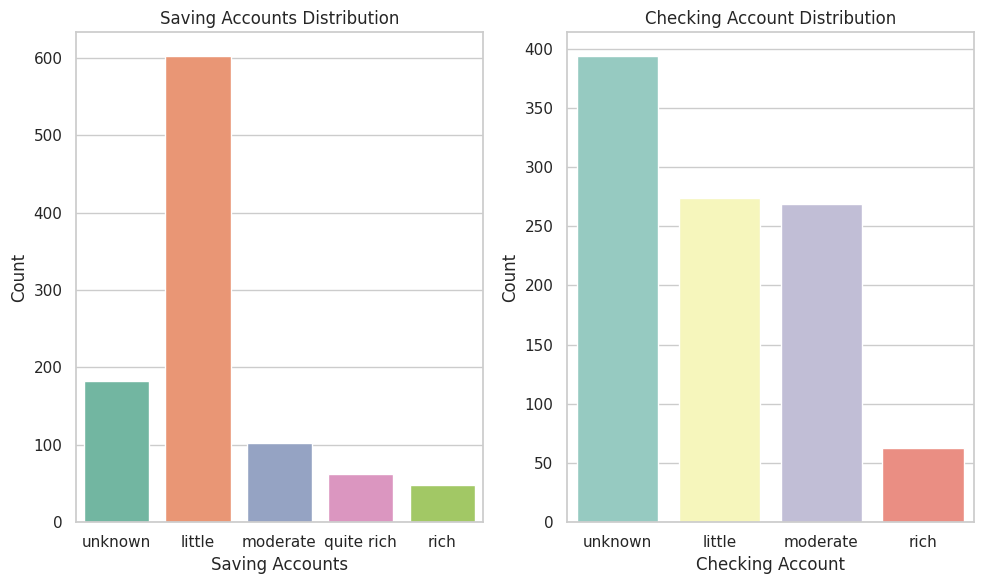

In [12]:
order_savings = ['unknown', 'little', 'moderate', 'quite rich', 'rich']
order_checking = ['unknown', 'little', 'moderate', 'rich']

fig, axs = plt.subplots(1, 2, figsize=(10,6))

# Savings account status distribution
sns.countplot(x='Saving accounts', data=data, order=order_savings, palette='Set2', ax=axs[0])
axs[0].set_title('Saving Accounts Distribution')
axs[0].set_xlabel('Saving Accounts')
axs[0].set_ylabel('Count')

# Checking account status distribution
sns.countplot(x='Checking account', data=data, order=order_checking, palette='Set3', ax=axs[1])
axs[1].set_title('Checking Account Distribution')
axs[1].set_xlabel('Checking Account')
axs[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

**From the above figure, we can know:**
1. The richer the customer, the less likely they are to choose a loan.
2. The customers with a small savings account have the most loans.
3. The number of customers with unknown, small, and medium checking account status is relatively large, especially the unknown customers, which indicates that the checking account may not be a major consideration when lending, which leads to the majority of unknown data.

### 3.3 **Customer loan situation analysis**

<ipython-input-13-fae62fa54fd2>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Credit amount'], kde=True, bins=30, ax=ax1)
<ipython-input-13-fae62fa54fd2>:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Duration'], kde=True, bins=20, color='green', ax=ax2)
<ipython-input-13-fae62

Text(0, 0.5, 'Purpose')

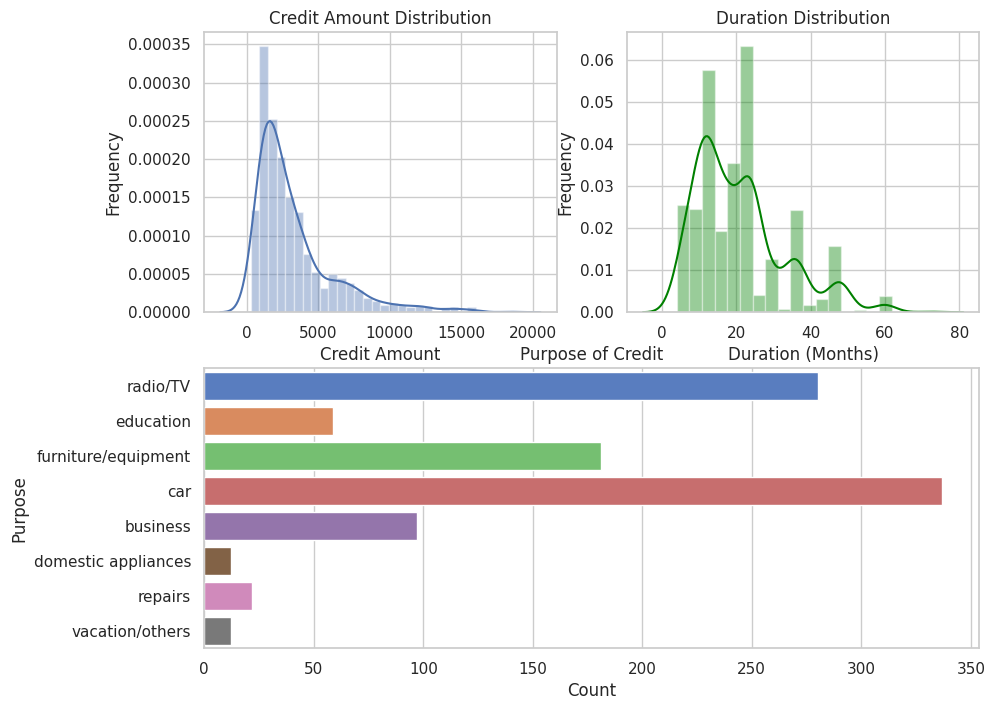

In [13]:
fig = plt.figure(figsize=(10,8))

# Create a 2x2 graph layout
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 1, 2)

# Distribution of loan amount
sns.distplot(data['Credit amount'], kde=True, bins=30, ax=ax1)
ax1.set_title('Credit Amount Distribution')
ax1.set_xlabel('Credit Amount')
ax1.set_ylabel('Frequency')

# Distribution of loan term
sns.distplot(data['Duration'], kde=True, bins=20, color='green', ax=ax2)
ax2.set_title('Duration Distribution')
ax2.set_xlabel('Duration (Months)')
ax2.set_ylabel('Frequency')

# Distribution of loan purpose
sns.countplot(y='Purpose', data=data, palette='muted', ax=ax3)
ax3.set_title('Purpose of Credit')
ax3.set_xlabel('Count')
ax3.set_ylabel('Purpose')

**From the above chart, we can know that:**
1. Customers tend to apply for medium-to-low amount loans, and the loan period is mainly medium-to-short term.
2. Customers mainly use loans to buy cars, radios/TVs, and furniture/equipment.

## 4. **Customer loan risk assessment**

### 4.1 **Data Pre-process**

When performing **clustering** on data, it is essential to process both numerical and categorical features appropriately so that the clustering algorithm can treat them in a consistent and meaningful way. Here's **why encoding and normalizing are necessary:**
1. **Clustering algorithms such as k-means**, hierarchical clustering, or DBSCAN work with **numerical** data. Categorical variables (like Sex, Housing, Saving accounts, etc.) need to be transformed into a numerical format for these algorithms to understand and process the data effectively.
2. **Numerical** **features** (such as Age, Credit amount, Duration) **can vary significantly in scale**. For example, the Credit amount may range from hundreds to thousands, while Age may only range from 18 to 70. These differences in scale can distort clustering results, as **features with larger scales might dominate the calculation of distances between data points**.
**Why normalization is needed:**

* Equal scaling: Normalizing the numerical data brings all the features to a common scale, typically by subtracting the mean and dividing by the standard deviation (z-score normalization). This ensures that no single feature disproportionately influences the clustering process.
* Improves algorithm performance: Clustering algorithms like k-means rely on distance metrics (e.g., Euclidean distance). Without normalization, features with larger magnitudes can skew the distance calculations, leading to biased clustering results.


---



**In summary:**
1. Encoding categorical variables ensures that non-numerical data can be processed by clustering algorithms.
2. Normalizing numerical features ensures that all features contribute equally to the clustering process, regardless of their original scale.



In [14]:
# Select features
features = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration']
new_data = data[features].copy()

# Encode categorical features
new_data['Sex'] = new_data['Sex'].map({
    'female': 0,
    'male': 1})

new_data['Housing'] = new_data['Housing'].map({
    'free': 0,
    'rent': 1,
    'own': 2})

new_data['Saving accounts'] = new_data['Saving accounts'].map({
    'unknown': 0,
    'little': 1,
    'moderate': 2,
    'quite rich': 3,
    'rich': 4})

new_data['Checking account'] = new_data['Checking account'].map({
    'unknown': 0,
    'little': 1,
    'moderate': 2,
    'rich': 3})

# Normalize numerical features
scaler = StandardScaler()
num_features = ['Age', 'Credit amount', 'Duration']
new_data[num_features] = scaler.fit_transform(new_data[num_features])

new_data.sample(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration
319,-0.751642,0,1,2,1,1,0.131761,-0.489762
761,-1.015499,0,2,1,1,1,-0.406638,-0.240857
486,1.447170,1,2,2,1,0,-0.068853,-0.738668
408,-0.839594,1,3,2,3,0,-0.012851,0.256953
561,-1.015499,1,1,1,1,1,-0.611506,0.256953
950,0.391740,1,0,2,1,2,0.112976,-0.240857
681,0.127883,1,2,0,0,0,-0.351699,-0.738668
816,2.326694,1,2,2,3,0,-0.685230,-1.236478
210,-0.223927,1,2,2,0,0,-0.069917,-0.987573
230,-0.839594,1,2,2,1,3,0.332731,1.252574


To find the optimal number of clusters for k-means clustering, **Silhouette Score** is a very common technique:

**The Silhouette Score measures how similar an object is to its own cluster compared to other clusters. A high Silhouette Score indicates that the object is well matched to its cluster and poorly matched to neighboring clusters.**


---


**Steps:**
1. Run k-means for different K values (e.g., 2 to 10).
2. Compute the Silhouette Score for each K.
3. The optimal K is the one with the highest Silhouette Score.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

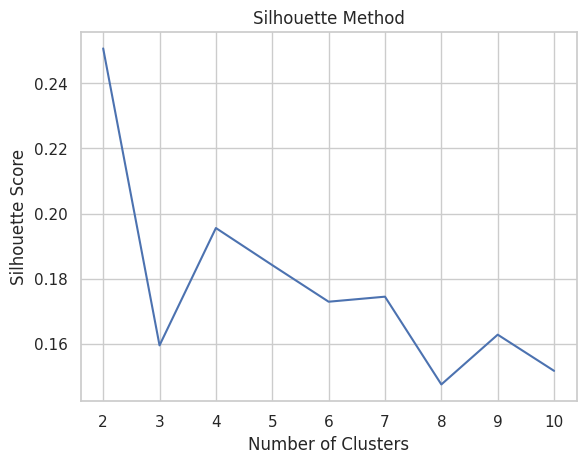

In [15]:
silhouette_scores = []

# Testing for cluster sizes from 2 to 10 (K=1 doesn't have meaning in silhouette)
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(new_data)
    score = silhouette_score(new_data, kmeans.labels_)
    silhouette_scores.append(score)

# Plot the Silhouette Score against number of clusters
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

**When Number of clusters is 2, we have the highest Silhouette Score, which exactly fits the purpose of this analysis. As we are just going to separate the customers into 'Hight Risk' and 'Low Risk'.**

### 4.2 **Separate customers into 2 groups/clusters using K means ++**

In [16]:
# Model selection: Clustering using KMeans++
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=15)
clusters = kmeans.fit_predict(new_data)

# Add the clustering results to the data
data['Risk Group'] = clusters
data.sample(10)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Id,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk Group
330,330,75,male,3,free,little,little,6615,24,car,1
829,829,38,male,2,free,unknown,moderate,6681,48,business,1
96,96,61,female,2,own,unknown,unknown,2012,12,education,0
638,638,34,female,2,own,little,unknown,1493,12,radio/TV,0
988,988,29,male,3,free,little,little,6579,24,car,1
17,17,25,male,2,own,unknown,little,8072,30,business,1
588,588,47,male,1,own,little,little,1217,18,domestic appliances,0
589,589,60,male,2,own,little,little,2246,12,furniture/equipment,0
787,787,38,male,2,own,unknown,unknown,2751,48,car,1
35,35,25,male,1,own,little,moderate,4746,45,radio/TV,1


### 4.3 **Comparison of 2 customer groups/clusters**

#### 4.3.1 **Basic Comparison**

Text(0, 0.5, 'Count')

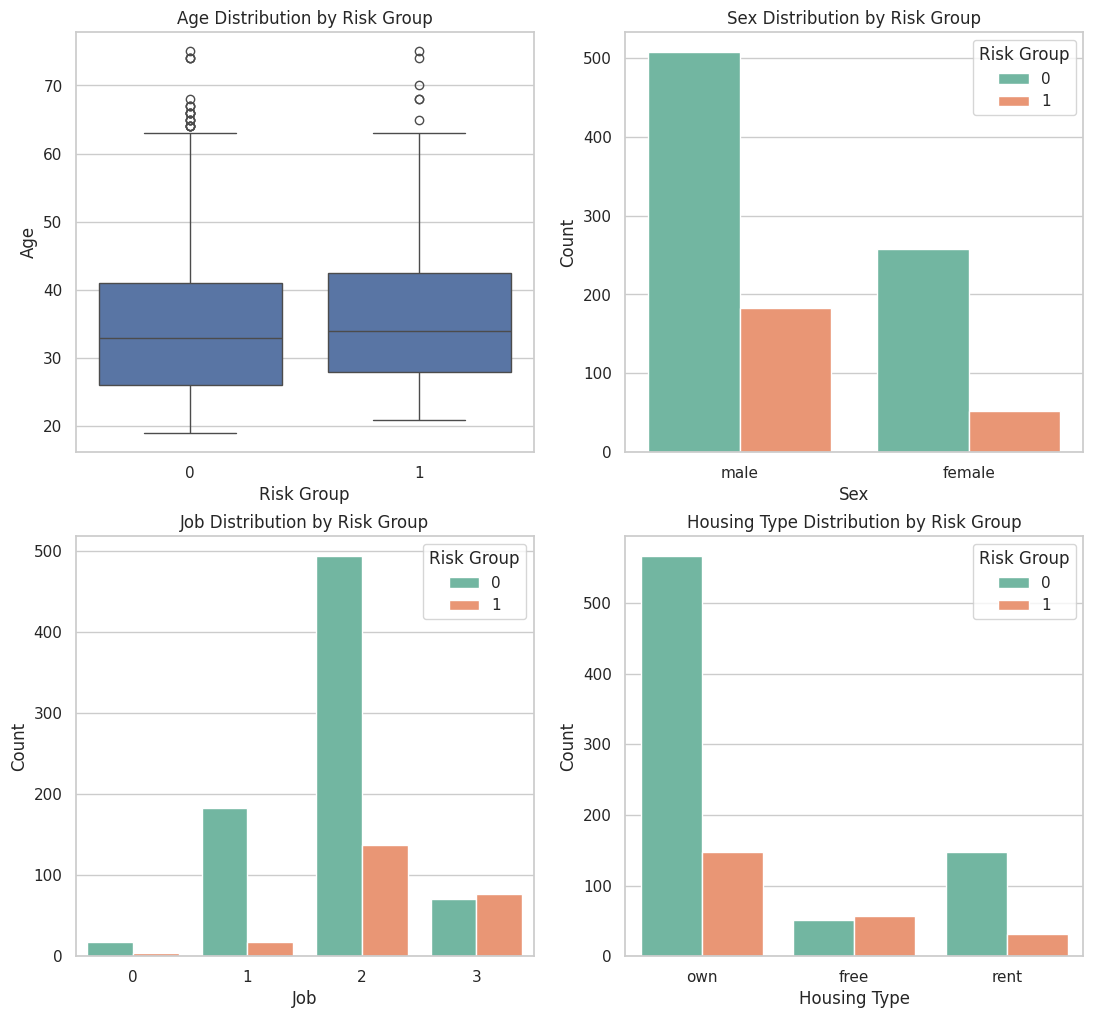

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(13,12))

sns.boxplot(x='Risk Group', y='Age', data=data, ax=axs[0, 0])
axs[0, 0].set_title('Age Distribution by Risk Group')
axs[0, 0].set_xlabel('Risk Group')
axs[0, 0].set_ylabel('Age')

sns.countplot(x='Sex', hue='Risk Group', data=data, palette='Set2', ax=axs[0, 1])
axs[0, 1].set_title('Sex Distribution by Risk Group')
axs[0, 1].set_xlabel('Sex')
axs[0, 1].set_ylabel('Count')

sns.countplot(x='Job', hue='Risk Group', data=data, palette='Set2', ax=axs[1, 0])
axs[1, 0].set_title('Job Distribution by Risk Group')
axs[1, 0].set_xlabel('Job')
axs[1, 0].set_ylabel('Count')

sns.countplot(x='Housing', hue='Risk Group', data=data, palette='Set2', ax=axs[1, 1])
axs[1, 1].set_title('Housing Type Distribution by Risk Group')
axs[1, 1].set_xlabel('Housing Type')
axs[1, 1].set_ylabel('Count')

#### 4.3.2 **Finance Comparison**



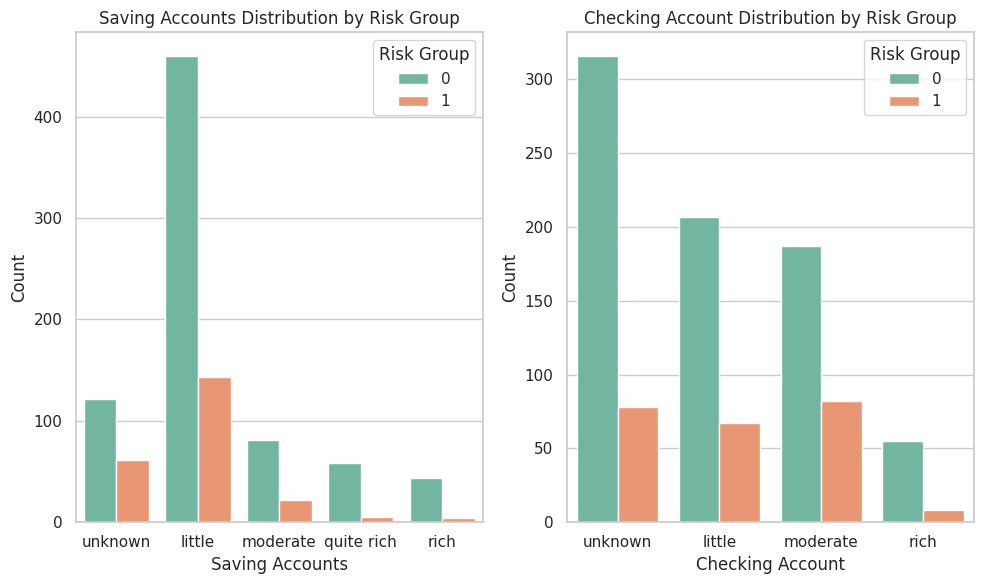

In [18]:
order_savings = ['unknown', 'little', 'moderate', 'quite rich', 'rich']
order_checking = ['unknown', 'little', 'moderate', 'rich']

fig, axs = plt.subplots(1, 2, figsize=(10,6))

sns.countplot(x='Saving accounts', hue='Risk Group', data=data, order=order_savings, palette='Set2', ax=axs[0])
axs[0].set_title('Saving Accounts Distribution by Risk Group')
axs[0].set_xlabel('Saving Accounts')
axs[0].set_ylabel('Count')

sns.countplot(x='Checking account', hue='Risk Group', data=data, order=order_checking, palette='Set2', ax=axs[1])
axs[1].set_title('Checking Account Distribution by Risk Group')
axs[1].set_xlabel('Checking Account')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

#### 4.3.3 **Loan Comparison**

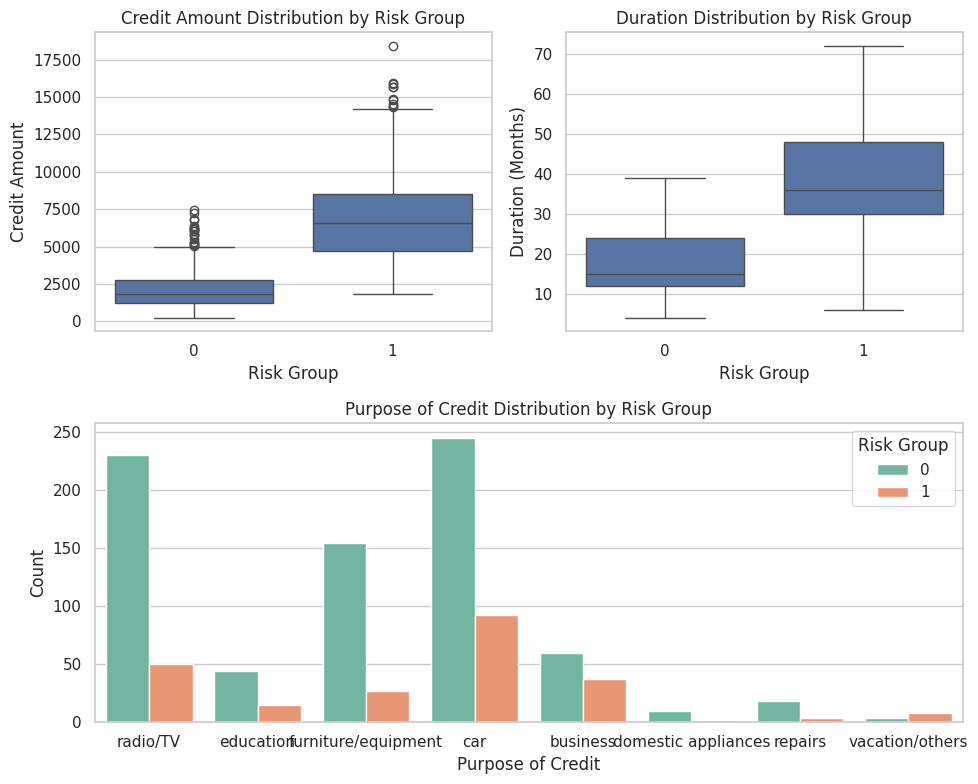

In [19]:
fig = plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 1, 2)

sns.boxplot(x='Risk Group', y='Credit amount', data=data, ax=ax1)
ax1.set_title('Credit Amount Distribution by Risk Group')
ax1.set_xlabel('Risk Group')
ax1.set_ylabel('Credit Amount')

sns.boxplot(x='Risk Group', y='Duration', data=data, ax=ax2)
ax2.set_title('Duration Distribution by Risk Group')
ax2.set_xlabel('Risk Group')
ax2.set_ylabel('Duration (Months)')

sns.countplot(x='Purpose', hue='Risk Group', data=data, palette='Set2', ax=ax3)
ax3.set_title('Purpose of Credit Distribution by Risk Group')
ax3.set_xlabel('Purpose of Credit')
ax3.set_ylabel('Count')

plt.tight_layout()
plt.show()

**Customers were divided into two risk groups: low risk (group 0) and high risk (group 1). The analysis shows that:**
* Low-risk group (Group 0): Customers tend to be older, more likely to own their home, and have higher levels of savings and checking accounts. They tend to take smaller loans with shorter durations, often for purposes like education or repairs.
* High-risk group (Group 1): Customers tend to be younger, rent their homes, and have lower levels of savings and checking accounts. They often take larger loans with longer durations, primarily for purchases like cars or furniture.

## 5. **Customer Persona**

This step is different from the previous step. I did not put the risk assessment situation into the cluster data. In this way, the number of clusters and the clustering situation can be better determined through the original data, and whether the risk assessment is accurate can be judged based on the clustering results.

#### 5.1 **Determining the number of clusters**


In [20]:
inertia = [] # Elbow method
silhouette_scores = [] # Silhouette
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=15).fit(new_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(new_data, kmeans.labels_))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

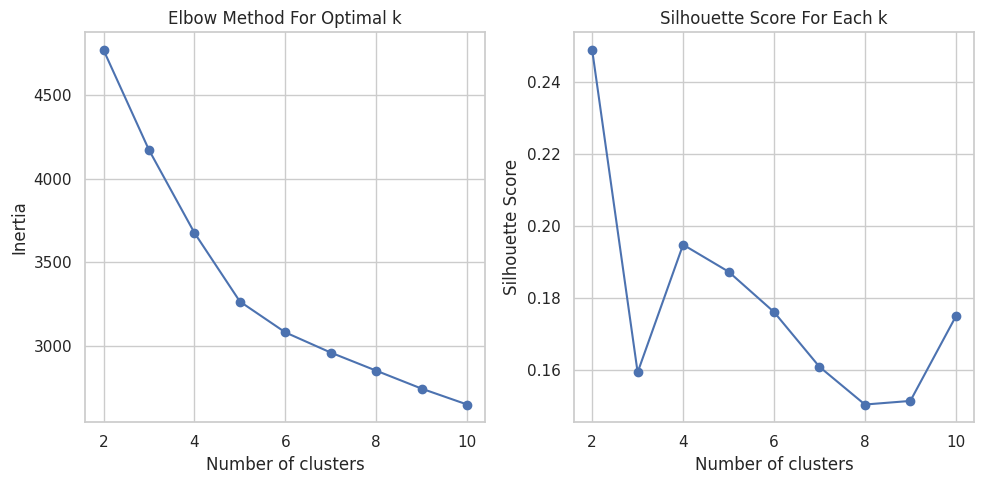

In [21]:
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Each k')

plt.tight_layout()
plt.show()

1. The left figure is the elbow rule graph. From this figure, we can see that the curve descent rate decreases significantly at 4 and 5.
2. The right figure is the silhouette coefficient graph. At 2, the silhouette coefficient is the highest, and it is also good at 4.
Combining the two figures, we choose 4 as the number of clusters. At this time, the elbow rule graph descent rate has a significant decrease, and it is the second highest point in the silhouette coefficient graph.

#### 5.2 **Build K-means clustering model using 4 clusters**


In [22]:
# Perform K-means clustering, select 4 clusters
kmeans_final = KMeans(n_clusters=4,init='k-means++', random_state=15)
kmeans_final.fit(new_data)

# Get cluster labels
cluster_labels = kmeans_final.labels_

# Add cluster labels to orginal data for analysis
data['Cluster'] = cluster_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


#### 5.2.1 **Basic Comparison**

Text(0, 0.5, 'Count')

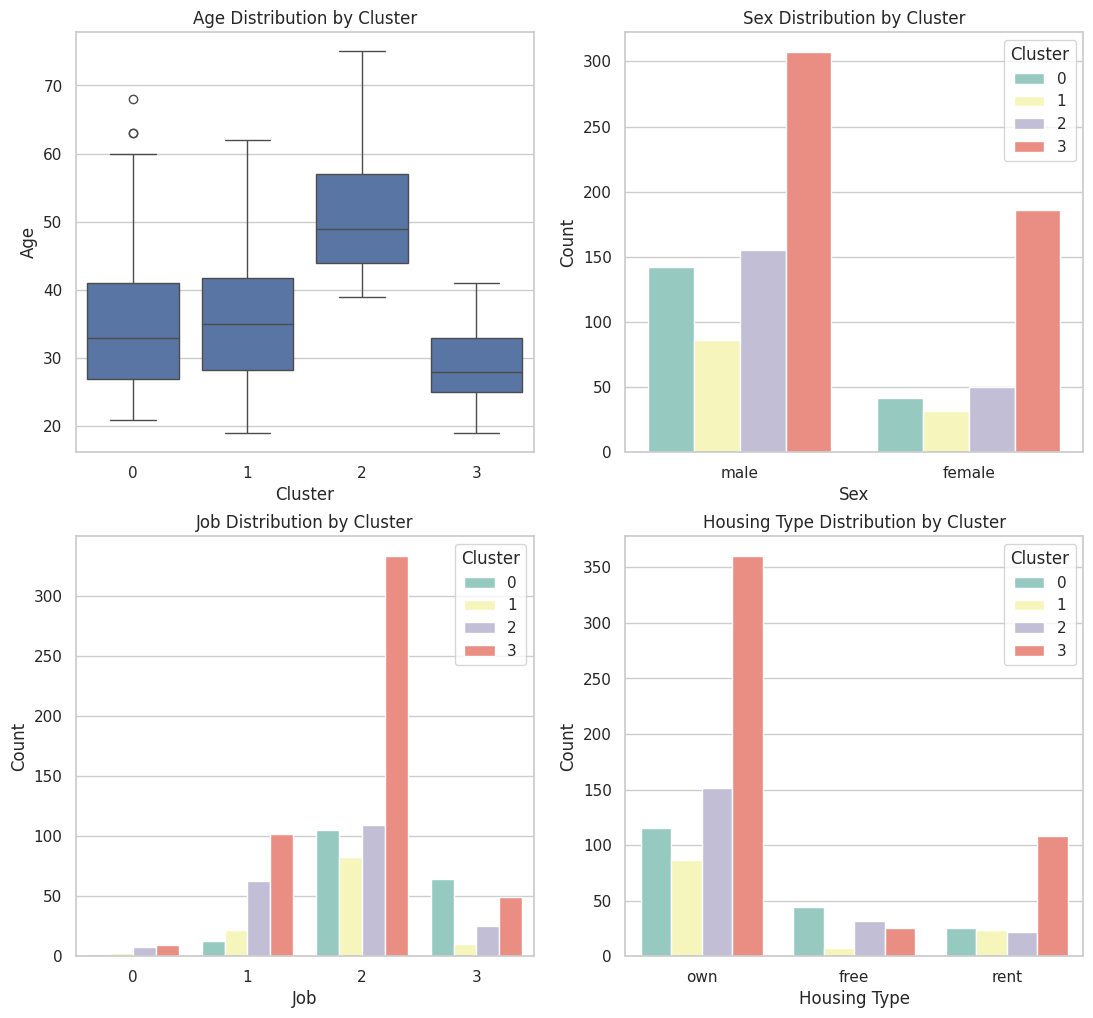

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(13,12))

sns.boxplot(x='Cluster', y='Age', data=data, ax=axs[0, 0])
axs[0, 0].set_title('Age Distribution by Cluster')
axs[0, 0].set_xlabel('Cluster')
axs[0, 0].set_ylabel('Age')

sns.countplot(x='Sex', hue='Cluster', data=data, palette='Set3', ax=axs[0, 1])
axs[0, 1].set_title('Sex Distribution by Cluster')
axs[0, 1].set_xlabel('Sex')
axs[0, 1].set_ylabel('Count')

sns.countplot(x='Job', hue='Cluster', data=data, palette='Set3', ax=axs[1, 0])
axs[1, 0].set_title('Job Distribution by Cluster')
axs[1, 0].set_xlabel('Job')
axs[1, 0].set_ylabel('Count')

sns.countplot(x='Housing', hue='Cluster', data=data, palette='Set3', ax=axs[1, 1])
axs[1, 1].set_title('Housing Type Distribution by Cluster')
axs[1, 1].set_xlabel('Housing Type')
axs[1, 1].set_ylabel('Count')

#### 5.2.2 **Finance Comparison**

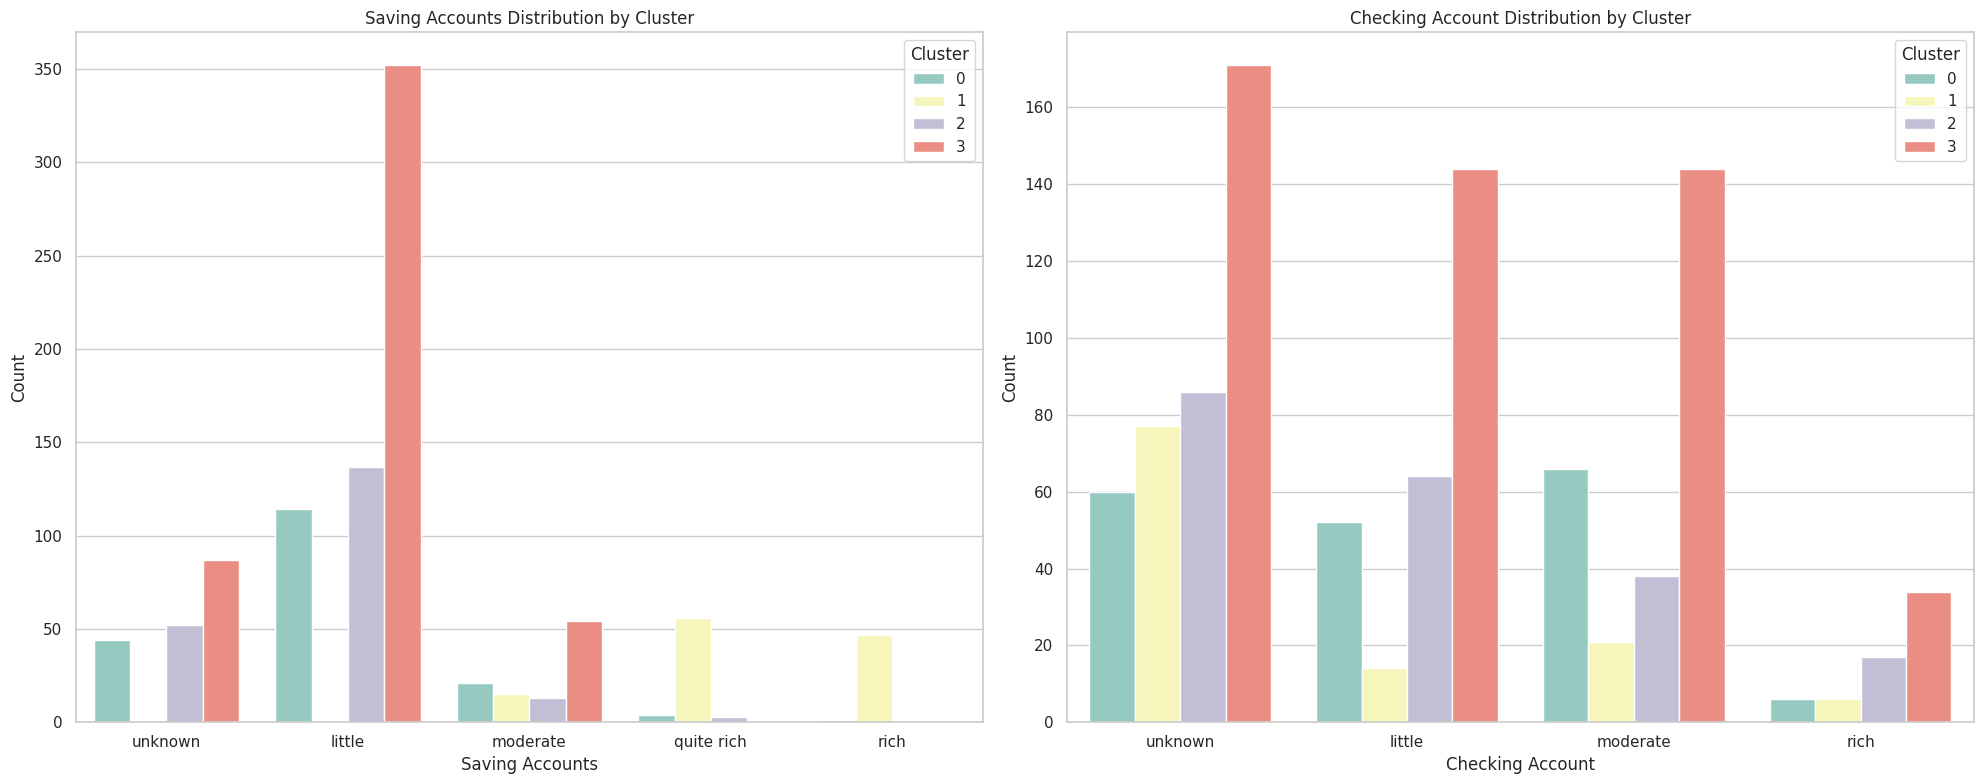

In [24]:
order_savings = ['unknown', 'little', 'moderate', 'quite rich', 'rich']
order_checking = ['unknown', 'little', 'moderate', 'rich']

fig, axs = plt.subplots(1, 2, figsize=(20,8))

sns.countplot(x='Saving accounts', hue='Cluster', data=data, order=order_savings, palette='Set3', ax=axs[0])
axs[0].set_title('Saving Accounts Distribution by Cluster')
axs[0].set_xlabel('Saving Accounts')
axs[0].set_ylabel('Count')
axs[0].legend(title='Cluster', loc='upper right')

sns.countplot(x='Checking account', hue='Cluster', data=data, order=order_checking, palette='Set3', ax=axs[1])
axs[1].set_title('Checking Account Distribution by Cluster')
axs[1].set_xlabel('Checking Account')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

#### 5.2.3 **Loan Comparison**

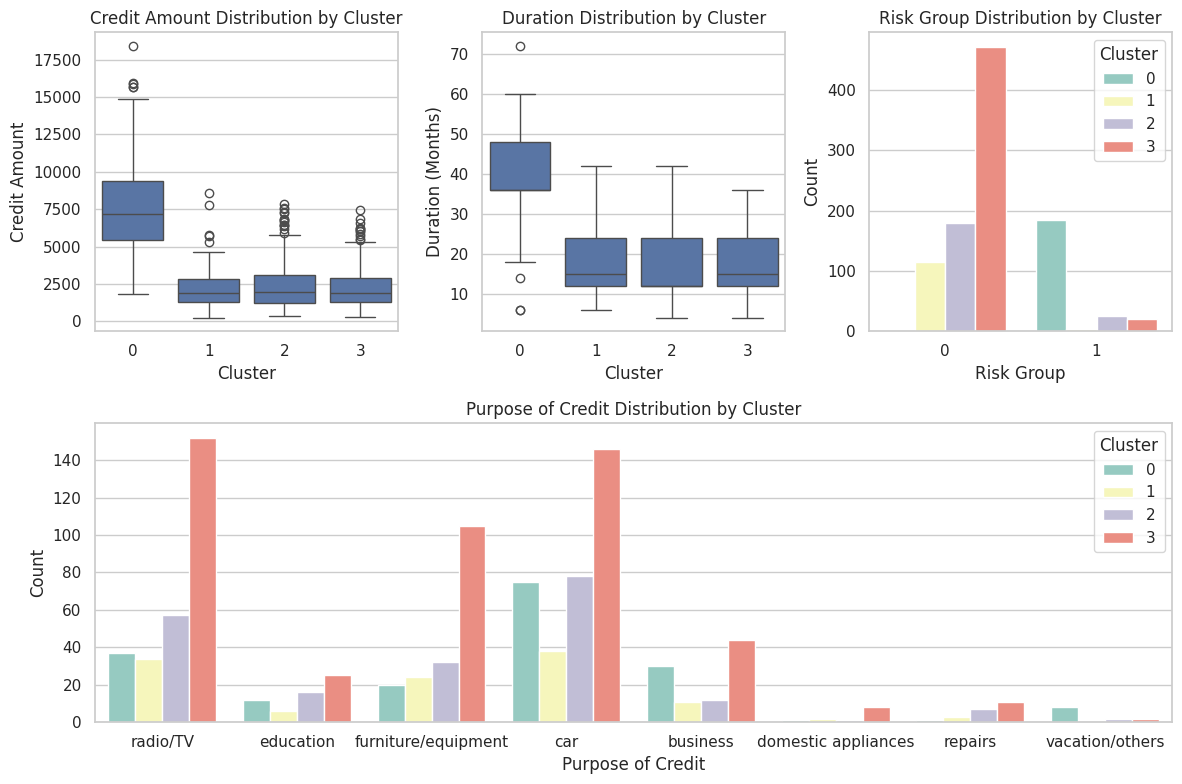

In [25]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)
ax4 = fig.add_subplot(2, 1, 2)

sns.boxplot(x='Cluster', y='Credit amount', data=data, ax=ax1)
ax1.set_title('Credit Amount Distribution by Cluster')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Credit Amount')

sns.boxplot(x='Cluster', y='Duration', data=data, ax=ax2)
ax2.set_title('Duration Distribution by Cluster')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Duration (Months)')

sns.countplot(x='Risk Group', hue='Cluster', data=data, palette='Set3', ax=ax3)
ax3.set_title('Risk Group Distribution by Cluster')
ax3.set_xlabel('Risk Group')
ax3.set_ylabel('Count')

sns.countplot(x='Purpose', hue='Cluster', data=data, palette='Set3', ax=ax4)
ax4.set_title('Purpose of Credit Distribution by Cluster')
ax4.set_xlabel('Purpose of Credit')
ax4.set_ylabel('Count')

plt.tight_layout()
plt.show()

**Cluster 0: High-Risk Customers**

* Age: Generally younger (between 20 and 35).
* Housing: Mostly renters or living in free accommodations.
* Financial Standing: Likely to have little or unknown savings and checking accounts.
* Loan Usage: Apply for higher credit amounts with longer loan durations, often for purchases like cars or furniture.
* Job: More likely to have unskilled or moderately skilled jobs, indicating a less stable financial situation.

**Cluster 1: Low-Risk Customers**

* Age: Likely to be older.
* Housing: Predominantly homeowners.
* Financial Standing: Tend to have higher savings and checking accounts.
* Loan Usage: Apply for smaller, short-term loans, often for education, repairs, or smaller household needs.
* Job: More likely to have skilled or highly skilled jobs, showing financial stability.

**Cluster 2: Mid-Risk Customers**

* Age: A mix of young and middle-aged individuals.
* Housing: Split between owning and renting homes.
* Financial Standing: Moderate savings and checking accounts.
* Loan Usage: Apply for medium-sized loans, often for business, appliances, or personal purchases.
* Job: Hold jobs ranging from unskilled to moderately skilled, indicating moderate financial stability.

**Cluster 3: Low-Risk, Conservative Borrowers**

* Age: Generally older (middle-aged to elderly).
* Housing: Predominantly homeowners with more financial stability.
* Financial Standing: Likely to have moderate to rich savings, with strong financial habits.
* Loan Usage: Tend to apply for loans with smaller amounts and shorter durations, typically for conservative purposes such as home improvements, repairs, or small personal needs.
* Job: Skilled or highly skilled jobs, often nearing retirement or with established financial security.

## 6. **Random Forest Model**

After constructing the user portrait, it can be considered that the results of the customer loan risk assessment are relatively correct. Therefore, a random forest model can be established to predict whether the customer is at high risk and to explore which feature is an important factor in dividing the risk.

#### 6.1 **Data Pre-process**

In [26]:
x = new_data
y = data['Risk Group']

# Use stratified sampling to ensure that the target values ​​in the training set and test set are similar to the distribution of the overall data set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10, stratify=y) #30% 70%

In [27]:
# Separation of Minority and Majority Classes
x_minority = x_train[y_train == 0]
y_minority = y_train[y_train == 0]
x_majority = x_train[y_train == 1]
y_majority = y_train[y_train == 1]
x_minority_resampled = resample(x_minority, replace=True, n_samples=len(x_majority), random_state=15)
y_minority_resampled = resample(y_minority, replace=True, n_samples=len(y_majority), random_state=15)
new_x_train = pd.concat([x_majority, x_minority_resampled])
new_y_train = pd.concat([y_majority, y_minority_resampled])

In [28]:
is_in_train = x_train.apply(lambda row: row.isin(new_x_train).all(), axis=1)
duplicates_in_test = x_train[is_in_train]

print(f"The number of rows in the test set that are included in the training set: {duplicates_in_test.shape[0]}")

The number of rows in the test set that are included in the training set: 0


#### 6.2 **RFM Model**

In [29]:
rf_clf = RandomForestClassifier(random_state = 15)
rf_clf.fit(new_x_train, new_y_train)

RandomForestClassifier(random_state=15)

#### 6.3 **Model Assessment**

In [30]:
y_pred_rf = rf_clf.predict(x_test)
class_report_rf = classification_report(y_test, y_pred_rf)
print(class_report_rf)

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       229
           1       0.85      1.00      0.92        71

    accuracy                           0.96       300
   macro avg       0.92      0.97      0.94       300
weighted avg       0.96      0.96      0.96       300



Class 0:

* Precision: 1.00 (100%) — Of all the predictions made for class 0, 100% were correct.
* Recall: 0.94 (94%) — The model identified 94% of the true class 0 samples.
* F1-Score: 0.97 — This is the harmonic mean of precision and recall, indicating a balanced performance.
* Support: 229 — There were 229 true samples for class 0.

Class 1:

* Precision: 0.85 (85%) — Of all the predictions made for class 1, 85% were correct.
* Recall: 1.00 (100%) — The model identified all the true class 1 samples.
* F1-Score: 0.92 — A strong F1-score, balancing precision and recall.
* Support: 71 — There were 71 true samples for class 1.
* Accuracy: 0.96 (96%) — The model correctly classified 96% of the total 300 samples.

Macro Average:

* Averages precision, recall, and F1-score across both classes equally (without considering the class sizes).
* Precision: 0.92
* Recall: 0.97
* F1-Score: 0.94

Weighted Average:

* Averages precision, recall, and F1-score across both classes, weighted by the number of samples in each class.
* recision: 0.96
* Recall: 0.96
* F1-Score: 0.96

**Key Takeaways:**
* The model performs very well overall, with high accuracy and strong scores for both precision and recall.
* Class 0 has higher precision, while class 1 has perfect recall but slightly lower precision.
* The weighted averages closely reflect the model's overall performance due to the larger number of class 0 samples.

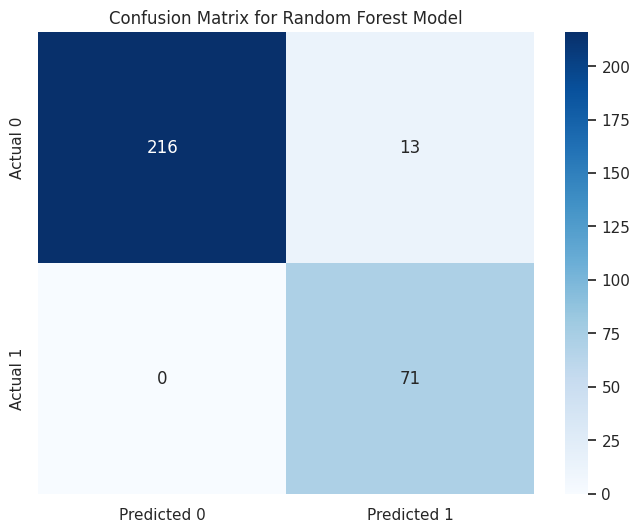

In [31]:
# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

#### 6.4 **Feature Importance**

In [33]:
rf_feature_importance = rf_clf.feature_importances_
feature_names = new_x_train.columns
rf_feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_feature_importance
})
sorted_rf_feature_df = rf_feature_df.sort_values(by = 'Importance', ascending = False).head(6) # filter the top 6 important features
sorted_rf_feature_df

,Feature,Importance
6,Credit amount,0.456412
7,Duration,0.369058
2,Job,0.052680
0,Age,0.040421
4,Saving accounts,0.038583
3,Housing,0.020380
